In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

#point-based estimate
from scipy.optimize import curve_fit
from scipy.integrate import odeint

#interval-based estimate
import pystan
import arviz as az

from sklearn.metrics import r2_score

#### Plotting Function

In [2]:
def plot_trace(params, param_name='parameter', num_cols=2):
    
    num_rows = int(len(params)/num_cols)
    f, ax = plt.subplots(num_rows, num_cols*2, figsize=(7*num_cols, 2*num_rows))
    
    for i in tqdm(range(num_rows)):
        for j in range(num_cols):
            
            param = params[i*num_cols+j]
        
            mean = np.mean(param)
            median = np.median(param)
            cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

            ax[i, j*2].plot(param, label='chain-{}'.format(i*num_cols+j))
            ax[i, j*2].axhline(mean, color='r', lw=2, linestyle='--')
            ax[i, j*2].axhline(median, color='c', lw=2, linestyle='--')
            ax[i, j*2].axhline(cred_min, linestyle=':', color='k')
            ax[i, j*2].axhline(cred_max, linestyle=':', color='k')
            ax[i, j*2].legend(loc=1)
            
            ax[i, j*2+1].hist(param, 30, density=True);
            sns.kdeplot(param, shade=True, ax=ax[i, j*2+1])
            ax[i, j*2+1].axvline(mean, color='r', lw=2, linestyle='--', label='mean')
            ax[i, j*2+1].axvline(median, color='c', lw=2, linestyle='--', label='median')
            ax[i, j*2+1].axvline(cred_min, linestyle=':', color='k', label='95% CI')
            ax[i, j*2+1].axvline(cred_max, linestyle=':', color='k')
            ax[i, j*2+1].set_ylabel(None)
            ax[i, j*2+1].legend(loc=1)
    
    plt.suptitle(param_name)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

#### Growth Model

In [30]:
def growth_rate(OD, alpha, beta):
    return (alpha * (1 - (OD/beta)))

#growth curve
def od_inference(t, r, c, y0):

    def od_model(OD, t, r, c):
        dOD = growth_rate(OD[0], r, c) * OD[0]
        return dOD
    
    solution = odeint(od_model, y0, t, (r, c))
    return np.array(solution.T[0])

In [166]:
ods = pd.read_csv('datasets/marionette_od.csv', index_col='time')
gates = ['e11x32STPhoRadA', 'e15x32NpuSspS2', 'e16x33NrdA2', 'e20x32gp411', 'e32x30SspGyrB',
         'e34x30MjaKlbA', 'e38x32gp418', 'e41x32NrdJ1', 'e42x32STIMPDH1', 'positive_control', 'negative_control']

In [187]:
gate = 'e38x32gp418'
od = ods['{}_11'.format(gate)]

In [190]:
lang = 'pymc3'
loaded = az.from_netcdf('datasets/{}_ods/{}.nc'.format(lang, gate))

if lang!='stan':
    r = np.array(loaded['posterior']['r'])
    c = np.array(loaded['posterior']['c'])
    y0 = np.array(loaded['posterior']['y0'])
else:
    num_params = np.array(loaded['posterior']['theta']).shape[2]
    thetas= []
    for i in range(num_params):
        thetas.append(np.array(loaded['posterior']['theta'])[:,:,i])
    y0 = np.array(loaded['posterior']['y0'])
    sigma = np.array(loaded['posterior']['sigma'])

100%|██████████| 3/3 [00:00<00:00, 12.17it/s]


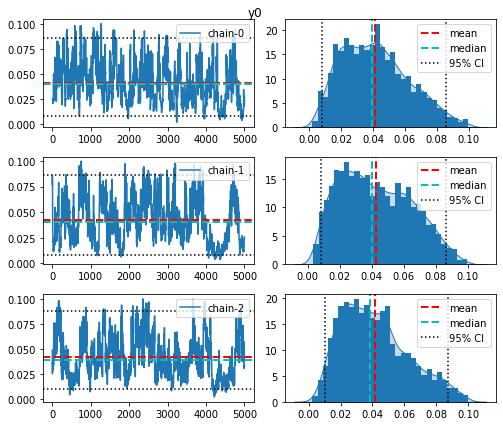

In [222]:
plot_trace(y0, 'y0', num_cols=1)

In [219]:
r = np.array(loaded['posterior']['r'])
c = np.array(loaded['posterior']['c'])
y0 = np.array(loaded['posterior']['y0'])

0 3000


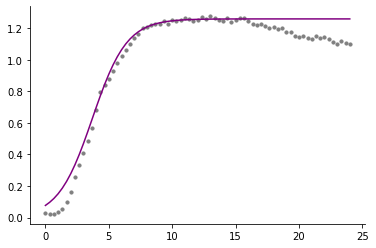

In [225]:
#chain, idx = np.random.randint(0, 3), np.random.randint(0, 5000)
chain, idx = 0, 3000
print(chain, idx)
popt = [r[chain][idx], c[chain][idx], y0[chain][idx]]
#popt = [thetas[0][chain][idx], thetas[1][chain][idx], y0[chain][idx]]
plt.plot(od.index/60, od_inference(od.index, *popt), color='purple')
plt.scatter(od.index/60, od, color='gray', s=10)
sns.despine()

#### Fluo Model

In [254]:
loaded = az.from_netcdf('datasets/bayesian_all/Marionette-20210726.nc')

In [255]:
loaded.posterior

<xarray.Dataset>
Dimensions:                  (chain: 1, draw: 3000)
Coordinates:
  * chain                    (chain) int64 0
  * draw                     (draw) int64 0 1 2 3 4 ... 2995 2996 2997 2998 2999
Data variables:
    syn_ECF_e41x32NrdJ1      (chain, draw) float64 ...
    syn_ECF_e32x30SspGyrB    (chain, draw) float64 ...
    syn_ECF_e42x32STIMPDH1   (chain, draw) float64 ...
    syn_ECF_e20x32gp411      (chain, draw) float64 ...
    syn_ECF_e15x32NpuSspS2   (chain, draw) float64 ...
    syn_ECF_e34x30MjaKlbA    (chain, draw) float64 ...
    syn_ECF_e38x32gp418      (chain, draw) float64 ...
    syn_ECF_e11x32STPhoRadA  (chain, draw) float64 ...
    syn_ECF_e16x33NrdA2      (chain, draw) float64 ...
Attributes:
    created_at:                 2021-07-26T06:17:14.694834
    arviz_version:              0.11.2
    inference_library:          pymc3
    inference_library_version:  3.11.2

In [ ]:
az.plot_trace(loaded)
sns.despine()

In [231]:
thetas= []
for i in labels:
    thetas.append(np.array(loaded['posterior'][i]))

In [230]:
num_params = np.array(loaded['posterior']['theta']).shape[2]
thetas= []
for i in range(num_params):
    thetas.append(np.array(loaded['posterior']['theta'])[:,:,i])
sigma = np.array(loaded['posterior']['sigma'])

KeyError: 'theta'

100%|██████████| 2/2 [00:00<00:00, 14.53it/s]


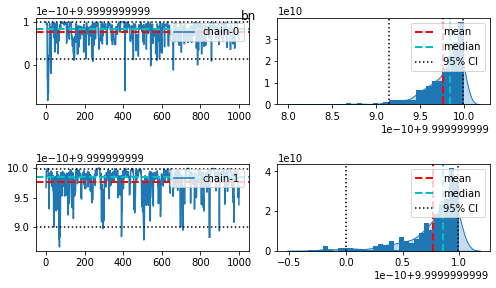

In [233]:
plot_trace(sigma, 'sigma', num_cols=2)

100%|██████████| 2/2 [00:00<00:00, 15.72it/s]


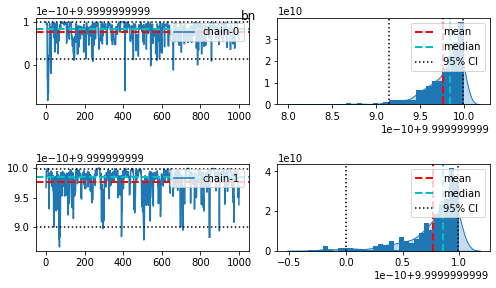

In [253]:
labels = ['bn', 'bc', 'bg', 'syn_ECFn', 'syn_ECFc', 'syn_ECF', 'syn_GFP', 'deg', 'deg_GFP', 'K', 'n']
i = 0
plot_trace(thetas[i], labels[i], num_cols=1)

Simulating the parameters.

In [ ]:
y_std = (y - y.mean()) / y.std()
x1_, x2_ = x1.ravel(), x2.ravel()
x1_std = (x1_ - x1_.mean()) / x1_.std()
x2_std = (x2_ - x2_.mean()) / x2_.std()
x_std = np.vstack((x1_std, x2_std))

In [ ]:
popt = [19.417468199900505,
 19.796305648408687,
 5.006270368883731,
 4.990379304603606,
 50.18749863385959,
 50.25055068229069,
 101.58235065313463,
 101.45629068698557]

In [ ]:
y_hat = hill_activation_and(x, *popt)
print(r2_score(y, y_hat))
sns.regplot(y, y_hat)
sns.despine()

In [ ]:
chain, idx = 0, 1000
popt = [theta[chain][idx] for theta in thetas]
y_hat = hill_activation_and(x, *popt)
#print(r2_score(y_std, y_hat))
#print(np.corrcoef(y_std, y_hat)[0][1])
sns.regplot(y, y_hat)
sns.despine()

In [ ]:
[(a, b) for a, b in zip(y_std, y_hat)]

In [ ]:
import sympy as sp

In [ ]:
k1,k2,n1,n2,y1min,y2min,y1max,y2max,x1,x1mean,x1std,x2,x2mean,x2std,y,ymean,ystd=sp.symbols('k1 k2 n1 n2 y1min y2min y1max y2max x1 x1mean x1std x2 x2mean x2std y ymean ystd',real=True)

In [ ]:
y=ystd*((y1min+((y1max-y1min)*(((x1-x1mean)/x1std)**n1/(((x1-x1mean)/x1std)**n1 + k1**n1))))*(y2min+((y2max-y2min)*(((x2-x2mean)/x2std)**n2/(((x2-x2mean)/x2std)**n2 + k2**n2)))))+ymean
y

In [ ]:
sp.simplify(y)

In [ ]:
y=((y1min+((y1max-y1min)*((x1-x1mean)/x1std)))*(y2min+((y2max-y2min)*((x2-x2mean)/x2std))))
y

### Alternative Model

In [ ]:
#at 24h
hill_params = {
    'e11x32STPhoRadA': [8.19215086e+00, 2.77324618e+00, 6.00000000e+00, 1.24643956e+00, 3.56423426e+00, 1.50252702e-10, 3.55907011e+02, 4.95959256e+02],
    'e15x32NpuSspS2': [9.8458614, 8.7957319, 2.89598247, 1.0 , 33.3864939, 26.68735596, 157.80098788, 157.51127152],
    'e16x33NrdA2': [10.13165313, 6.30849837, 5.02963422, 1.26435637, 12.31034403, 5.56520849, 389.61315225, 399.52903402],
    'e20x32gp411': [12.53828935, 1.0, 2.78451886, 1.49241488, 8.42038183, 19.770931, 316.74400613, 314.41729987],
    'e32x30SspGyrB': [10.77387795, 8.56616674, 3.12574014, 1.07032582, 12.42641636, 10.01199595, 353.07383233, 353.36938984],
    'e34x30MjaKlbA': [8.42632247, 13.40974257, 3.28555513, 1.81757507, 8.91852601, 20.20877259, 289.53290172, 287.92030858],
    'e38x32gp418': [7.61231223, 1.51099399, 5.04169259, 1.4068252, 22.75331651, 18.846011, 222.80791219, 223.15092773],
    'e41x32NrdJ1': [9.59574651, 12.05238497, 3.84271899, 1.0, 20.50936546, 14.68953094, 279.98024852, 280.45758993],
    'e42x32STIMPDH1': [10.41225458, 5.87647366, 4.30770405, 1.01184319, 19.08872036, 15.87715881, 232.88219568, 232.90886374]
}

In [ ]:
gate = 'e15x32NpuSspS2'
a, b = 5, 5
cuma, ara = cumas[a], aras[b]
fluo = fluos['{}_{}{}'.format(gate, a, b)]

In [ ]:
fluo.plot()
plt.axhline(fluo.min())
plt.axhline(fluo.max())

In [ ]:
yy = fluo.copy()
yyy = (yy - yy.mean()) / yy.std()

In [ ]:
plt.plot(yyy)
plt.axhline(yyy.min())
plt.axhline(yyy.max())

In [ ]:
loaded['posterior']

In [ ]:
loaded = az.from_netcdf('datasets/bayesian-trial-2/alternative/P3-Alternative-{}-{}{}.nc'.format(gate, a, b))
num_params = np.array(loaded['posterior']['theta']).shape[2]
thetas= []
for i in range(num_params):
    thetas.append(np.array(loaded['posterior']['theta'])[:,:,i])
y0 = np.array(loaded['posterior']['y0'])
sigma = np.array(loaded['posterior']['sigma'])

In [ ]:
loaded = az.from_netcdf('datasets/bayesian-trial-2/Metropolis-Alternative-e11x32STPhoRadA-55.nc')
r = np.array(loaded['posterior']['r'])
y0 = np.array(loaded['posterior']['y0'])
synGFP = np.array(loaded['posterior']['synGFP'])

In [ ]:
plt.hist(y0[1])

In [ ]:
plot_trace(y0, 'y0')

In [ ]:
plot_trace(thetas[0], 'r')

In [ ]:
plot_trace(thetas[1], 'synGFP')

Simulating the parameters.

In [ ]:
chain, idx = 1, 1000
popt = [thetas[0][chain][idx], np.array(loaded['posterior']['y0'])[chain][idx], thetas[1][chain][idx], 0.01]
sim = gate_wrapper(fluo.index, *popt, cuma, ara, hill_params[gate])
plt.plot(fluo.index/60, sim[0], color='red', label='gate')
plt.plot(fluo.index/60, sim[1], color='purple', label='GFP')
plt.scatter(fluo.index/60, fluo, color='gray', label='data', s=10)
plt.legend()
sns.despine()

### Alternative Model

In [ ]:
#at 20h
hill_params = {
    'e11x32STPhoRadA': [8.19215086e+00, 2.77324618e+00, 6.00000000e+00, 1.24643956e+00, 3.56423426e+00, 1.50252702e-10, 3.55907011e+02, 4.95959256e+02],
    'e15x32NpuSspS2': [9.8458614, 8.7957319, 2.89598247, 1.0 , 33.3864939, 26.68735596, 157.80098788, 157.51127152],
    'e16x33NrdA2': [10.13165313, 6.30849837, 5.02963422, 1.26435637, 12.31034403, 5.56520849, 389.61315225, 399.52903402],
    'e20x32gp411': [12.53828935, 1.0, 2.78451886, 1.49241488, 8.42038183, 19.770931, 316.74400613, 314.41729987],
    'e32x30SspGyrB': [10.77387795, 8.56616674, 3.12574014, 1.07032582, 12.42641636, 10.01199595, 353.07383233, 353.36938984],
    'e34x30MjaKlbA': [8.42632247, 13.40974257, 3.28555513, 1.81757507, 8.91852601, 20.20877259, 289.53290172, 287.92030858],
    'e38x32gp418': [7.61231223, 1.51099399, 5.04169259, 1.4068252, 22.75331651, 18.846011, 222.80791219, 223.15092773],
    'e41x32NrdJ1': [9.59574651, 12.05238497, 3.84271899, 1.0, 20.50936546, 14.68953094, 279.98024852, 280.45758993],
    'e42x32STIMPDH1': [10.41225458, 5.87647366, 4.30770405, 1.01184319, 19.08872036, 15.87715881, 232.88219568, 232.90886374]
}

In [ ]:
print(gate, a, b)
sim = gate_wrapper(fluo.index, *gate_params, cumas[a], aras[b], hill_params[gate])
plt.plot(fluos.index/60, sim[0], color='red', label='gate')
plt.plot(fluos.index/60, sim[1], color='purple', label='GFP')
plt.scatter(fluos.index/60, fluo, color='gray', label='data', s=10)
plt.legend()
sns.despine()

In [ ]:
### STATIC MODELS ###
def hill_equation(x, K, n):
    return x**n / (K**n + x**n)

def growth_rate(t, OD, alpha, beta):
    return (alpha * (1 - (OD/beta)))

### ODE ###

#growth curve
def od_wrapper(t, r, c, c0):

    def od_model(OD, t, r, c):
        dOD = growth_rate(t, OD[0], r, c) * OD[0]
        return dOD
    
    od_sol = odeint(od_model, c0, t, (r, c))
    return np.array(od_sol[:,0])

#model with auto-fluorescence term
def gate_wrapper_complete(t, bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, a, K, n, ind1, ind2, extra, y0):
    
    #fixed parameters
    alpha, beta = extra

    def gate_model(y, t):
        
        #dependent variables
        ECFn, ECFc, ECF, GFP, Auto, OD = y
        
        gamma = growth_rate(t, OD, alpha, beta)
        #differential equations
        dOD = gamma * OD
        dECFn = bn + syn_ECFn * ind1 - (deg + gamma) * ECFn
        dECFc = bc + syn_ECFc * ind2 - (deg + gamma) * ECFc
        dECF = syn_ECF * ECFn * ECFc - (deg + gamma) * ECF
        
        dGFP = bg + syn_GFP * hill_equation(ECF, K, n) - (deg_GFP + gamma) * GFP
        dAuto = a - gamma * Auto

        return [dECFn, dECFc, dECF, dGFP, dAuto, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

#model with auto-fluorescence term
def gate_wrapper_complete(t, bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, a, K, n, ind1, ind2, extra, y0):
    
    #fixed parameters
    alpha, beta = extra

    def gate_model(y, t):
        
        #dependent variables
        ECFn, ECFc, ECF, GFP, Auto, OD = y
        
        gamma = growth_rate(t, OD, alpha, beta)
        #differential equations
        dOD = gamma * OD
        dECFn = bn + syn_ECFn * ind1 - (deg + gamma) * ECFn
        dECFc = bc + syn_ECFc * ind2 - (deg + gamma) * ECFc
        dECF = syn_ECF * ECFn * ECFc - (deg + gamma) * ECF
        
        dGFP = bg + syn_GFP * hill_equation(ECF, K, n) - (deg_GFP + gamma) * GFP
        dAuto = a - gamma * Auto

        return [dECFn, dECFc, dECF, dGFP, dAuto, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

#model without auto-fluorescence term
def gate_wrapper(t, bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, K, n, ind1, ind2, extra, y0):
    
    #fixed parameters
    alpha, beta = extra

    def gate_model(y, t):
        
        #dependent variables
        ECFn, ECFc, ECF, GFP, OD = y
        
        gamma = growth_rate(t, OD, alpha, beta)
        #differential equations
        dOD = gamma * OD
        dECFn = bn + syn_ECFn * ind1 - (deg + gamma) * ECFn
        dECFc = bc + syn_ECFc * ind2 - (deg + gamma) * ECFc
        dECF = syn_ECF * ECFn * ECFc - (deg + gamma) * ECF
        
        dGFP = bg + syn_GFP * hill_equation(ECF, K, n) - (deg_GFP + gamma) * GFP

        return [dECFn, dECFc, dECF, dGFP, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

#model only auto-fluorescence term
def gate_wrapper_auto(t, a, ind1, ind2, extra, y0):
    
    #fixed parameters
    alpha, beta = extra

    def gate_model(y, t):
        
        #dependent variables
        Auto, OD = y
        gamma = growth_rate(t, OD, alpha, beta)
        #differential equations
        dOD = gamma * OD
        dAuto = a - gamma * Auto
        return [dAuto, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

#model only auto-fluorescence term
def gate_wrapper_gfp(t, syn_GFP, deg_GFP, extra, y0):
    
    def gate_model(y, t):
        
        GFP, OD = y
        alpha, beta = extra
        
        gamma = growth_rate(t, OD, alpha, beta)
        dOD = gamma * OD
        dGFP = syn_GFP - (deg_GFP + gamma) * GFP

        return [dGFP, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

In [ ]:
def simulate_single_state(fluo, f_params, od_params):
    
    num_od_params = 3
    num_vars = 4
    ind1, ind2 = 1, 1
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, (od_params[0], od_params[1]), pd.Series(np.append(np.zeros(num_vars), od_params[2])))
        return pd.Series(fit[3])
    
    return model_fit(fluo.index, *f_params)

In [ ]:
od_params = {
    'e11x32STPhoRadA': [0.0070462352099844, 1.1229375761211622, 0.0973103761235306],
    'e15x32NpuSspS2': [0.0158706098949703, 1.1961969417584624, 0.0235672266874314],
    'e16x33NrdA2': [0.0148194554039306, 1.2408917618889663, 0.0251889022569271],
    'e20x32gp411': [0.0155212086766198, 1.2780552798586051, 0.0193773015388865],
    'e32x30SspGyrB': [0.0159760283755244, 1.150249628464946, 0.0196547733645749],
    'e34x30MjaKlbA': [0.0139910399333654, 1.147632550566836, 0.0235340568336425],
    'e38x32gp418': [0.0155869734557929, 1.2060333912302554, 0.0247131234412902],
    'e41x32NrdJ1': [0.0136188162357974, 1.2375665371324622, 0.0300644005159601],
    'e42x32STIMPDH1': [0.013165608798406, 1.278935730092542, 0.0216016431163906]
}

f_params = {
    'e42x32STIMPDH1': [3.603791540777875, 1.3511898653916996, 39.9998176845689, 6.065998344052423, 
                        3.3384474103706507, 0.4875070387022843, 0.6772492193102161, 0.19905746983366815, 
                        0.013290264735609849, 3.2059353187892787, 2.253921913358458]
}

In [ ]:
fluos = pd.read_csv('datasets/marionette_fluo.csv', index_col='time')
gate = 'e42x32STIMPDH1'
fluo = fluos.loc[:, fluos.columns.str.startswith(gate)].iloc[:,3]

simulated = simulate_single_state(fluo, f_params[gate], od_params[gate])

In [ ]:
plt.plot(fluo.index/60, simulated, color='darkred')
plt.scatter(fluo.index/60, fluo, color='gray', s=10)
plt.title(gate)
sns.despine()

### Animation

In [ ]:
%matplotlib inline
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython import display
plt.rcParams['animation.ffmpeg_path'] = 'utils/ffmpeg'

fig, ax = plt.subplots(figsize=(16, 6))
xdata, ydata = [], []
ln, = plt.plot([], [], 'ro')

def init():
    ax.set_xlim(0, 2*np.pi)
    ax.set_ylim(-1, 1)
    return ln,

def update(frame):
    xdata.append(frame)
    ydata.append(np.sin(frame))
    ln.set_data(xdata, ydata)
    return ln,

anim = FuncAnimation(fig, update, frames=np.linspace(0, 2*np.pi, 128),
                    init_func=init, blit=True)
#video = anim.to_html5_video()
#html = display.HTML(video)
#display.display(html)
#plt.close()
FFwriter = FFMpegWriter()
anim.save('datasets/basic_animation.mp4', writer=FFwriter)

In [ ]:
from matplotlib import animation
from matplotlib.animation import FuncAnimation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)
anim.save('datasets/test.gif', writer='imagemagick')
plt.show()